In [6]:
from astropy.io import ascii, fits
import numpy as np
import os
import glob
from astropy.time import Time
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from photutils.centroids import centroid_com
from photutils.aperture import CircularAperture,CircularAnnulus,aperture_photometry
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from astroquery.jplhorizons import HorizonsClass
from astroquery.jplhorizons import Horizons
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import astroscrappy
import pandas as pd
from astropy.modeling.models import Gaussian2D
from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import sigma_clip, gaussian_fwhm_to_sigma
import sep
import matplotlib as mpl
import warnings
from astropy.io.fits.verify import VerifyWarning
from matplotlib.backends.backend_pdf import PdfPages
warnings.simplefilter('ignore', category=VerifyWarning)


#####INPUT#########################    
Observatory = 'Q33' #Nayoro observatory

subpath = os.path.join('/Users/judy/Library/CloudStorage/Dropbox/Research/Pirka_MSI/')
# subpath = os.path.join('/Users/judy/Library/CloudStorage/Dropbox/Research/Pirka_MSI/20230925')

objpath = os.path.join(subpath,'pyMSItest')

Observatory = 'q33' #Observatory code
Target_name = 'HD204827'
target_type = 'STD' #STD #Ast
magfile = '.csv' #To bring the mag file.

FILE = glob.glob(os.path.join(objpath,'msi*.fits'))
FILE = sorted(FILE)

for n,file in enumerate(FILE):
    hdul = fits.open(file)[0]
    header = hdul.header
    print(file.split('/')[-1], header['OBJECT'],header['RET-ANG2'])
    if (n+1)%4==0:
        print()
#########################    

msi230627_812210.fits HD204827 0.0
msi230627_812211.fits HD204827 45.0
msi230627_812212.fits HD204827 22.5
msi230627_812213.fits HD204827 67.5

msi230627_812214.fits HD204827 0.0
msi230627_812215.fits HD204827 45.0
msi230627_812216.fits HD204827 22.5
msi230627_812217.fits HD204827 67.5



Aperture Dia = 3.00 X FWHM
/Users/judy/Library/CloudStorage/Dropbox/Research/Pirka_MSI/pyMSItest/msi230627_812210.fits


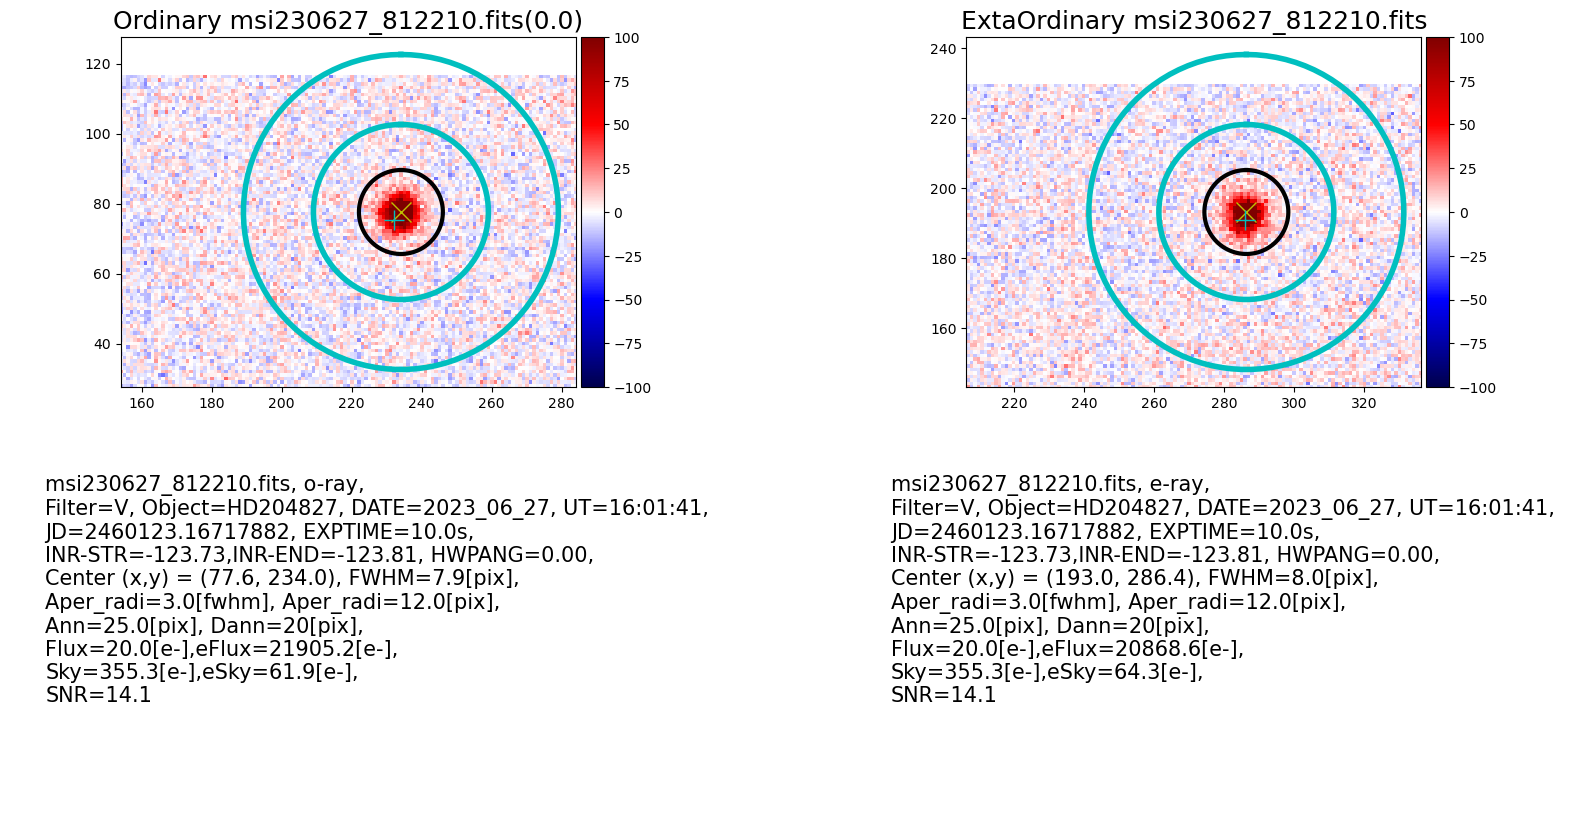

/Users/judy/Library/CloudStorage/Dropbox/Research/Pirka_MSI/pyMSItest/msi230627_812211.fits


<Figure size 640x480 with 0 Axes>

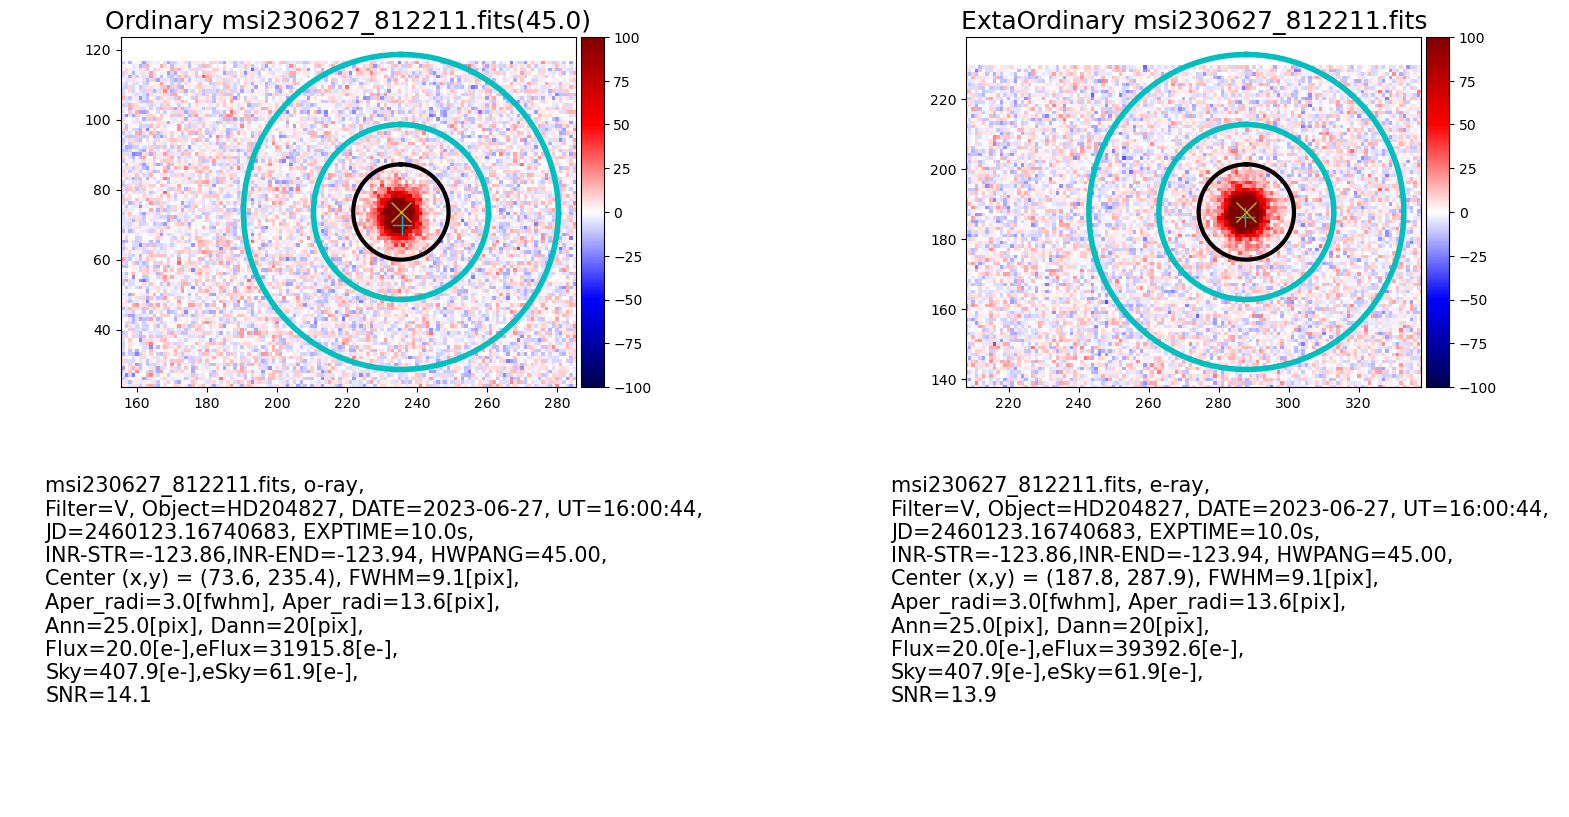

/Users/judy/Library/CloudStorage/Dropbox/Research/Pirka_MSI/pyMSItest/msi230627_812212.fits


<Figure size 640x480 with 0 Axes>

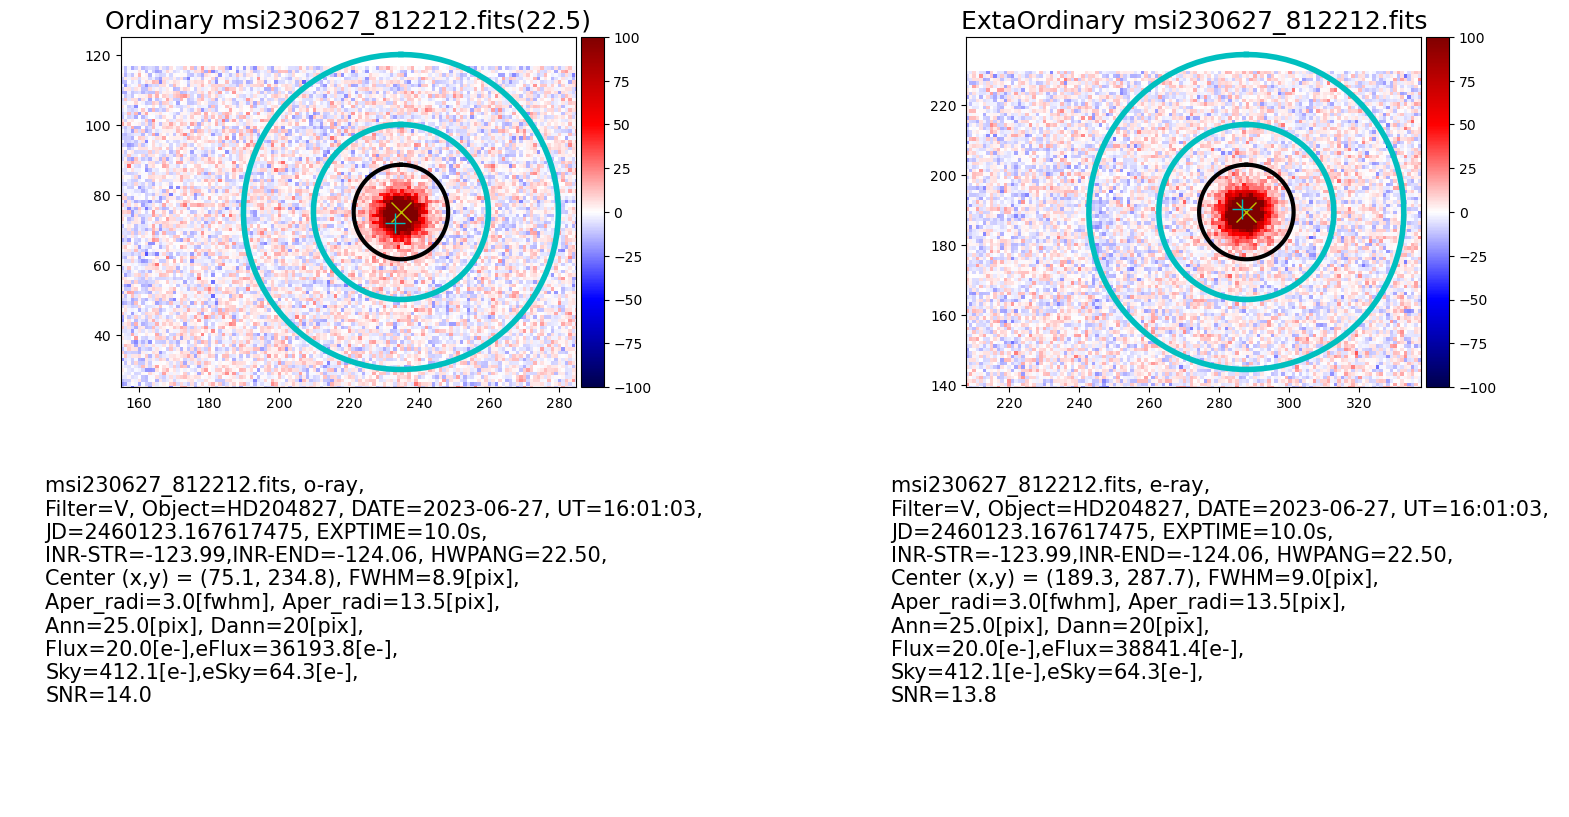

/Users/judy/Library/CloudStorage/Dropbox/Research/Pirka_MSI/pyMSItest/msi230627_812213.fits


<Figure size 640x480 with 0 Axes>

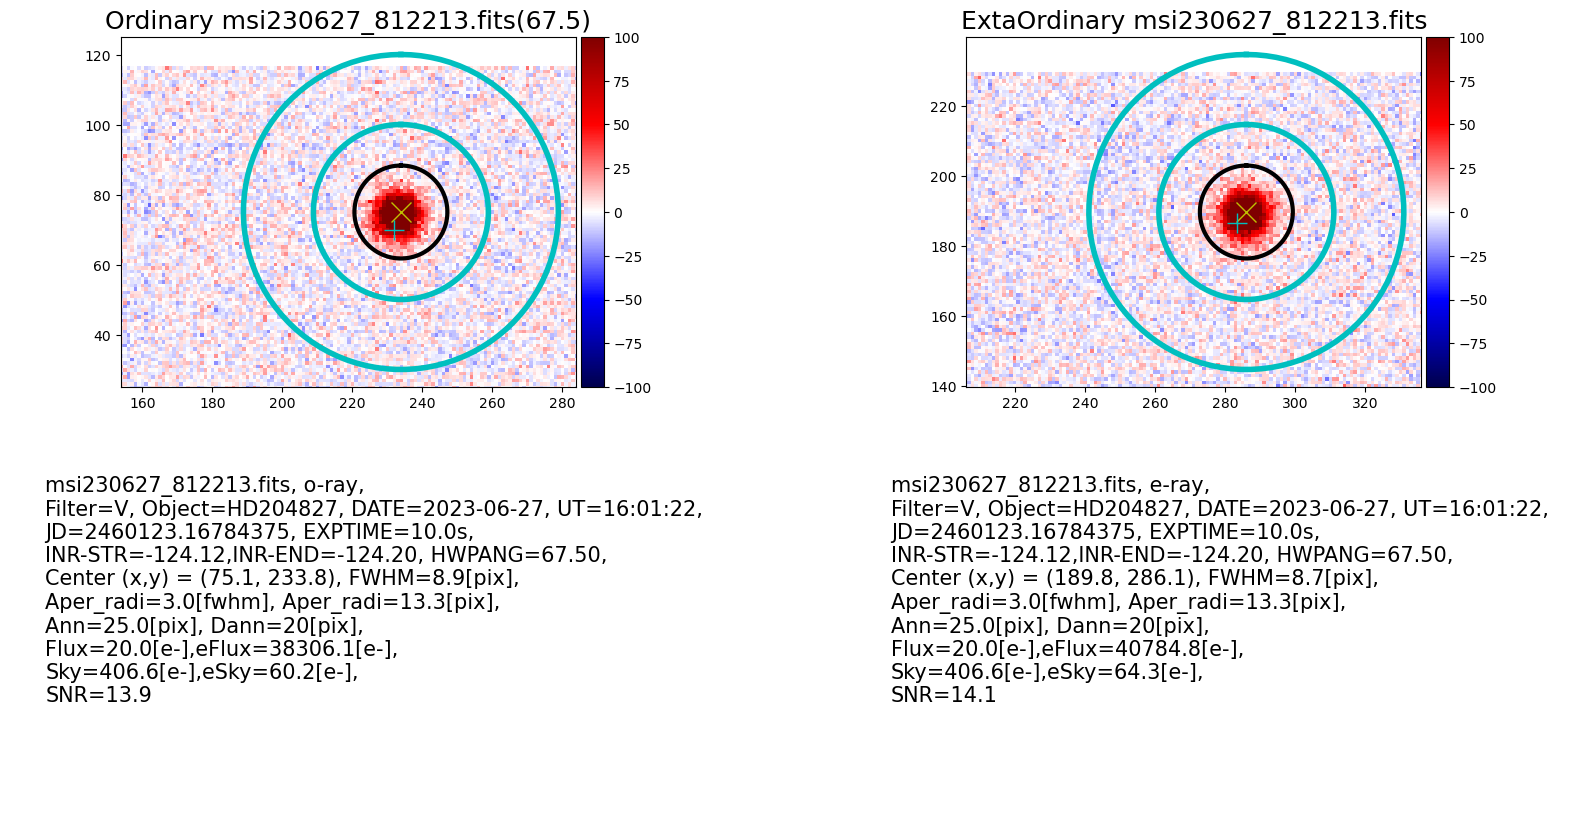

<Figure size 640x480 with 0 Axes>

In [72]:
#3. Apterture Photometry

#####INPUT#########################   
#CHECK THE APERTURE DEPENDENCY
fig_yes = 'yes'
aper= np.arange(1.6,3.5,0.1)
Ann =25
Dann =20
torelance = 20
#####INPUT#########################   

order = np.arange(0,len(FILE),4)[:1]
if fig_yes == 'yes':
    aper = [3] #radius = 3XFWHM



with PdfPages('output.pdf') as pdf:            
    for ap in aper: # aperture_radius = 1/2*FWHM * ap
        Log_aper = pd.DataFrame({})

        Photo_Log = pd.DataFrame({})
        print('Aperture Dia = {0:.2f} X FWHM'.format(ap))
        Log = pd.DataFrame({})

        for n_,z in enumerate(order):
            SET = [FILE[z],FILE[z+1], FILE[z+2], FILE[z+3]]
            I = [] # I_ex/I_o
            S = [] # (Sigma_{I_ex}/I_ex)**2 + (Sigma_{I_o}/I_o)**2  
            INR_STR = []
            INR_END = []
            PSANG = []
            PA = []
            file_name = SET[0].split('/')[-1].split('.')[0] +' ~ '+SET[3].split('/')[-1][-7:]
            aper_seri_o = ''
            aper_seri_e = ''
            JD_av = []
            AIRMASS_av = []
            delta_av = []
            r_av =[]
            EXP_av = []

    #         print('''
    #              ##################################################################################
    #                                                   SET {0}
    #              ##################################################################################

    #         '''.format(int(z/4 +1)))
            for i in range(0,4):
                ANG = ['0','45','22.5','67.5']
                File_ang = SET[i]  #Bring the fits file
                hdul = fits.open(File_ang)
                snr = 0
                print(File_ang)
                header = hdul[0].header 
                if header['NAXIS'] == 3:
                    data = hdul[0].data[0]
                else:
                    data = hdul[0].data
                #Bring the header info.==================================================
                iNR_STR = header['INR-STR']
                iNR_END = header['INR-END']
                INST_pa = header['INST-PA']


                JD = np.mean([header['MJD-STR'],header['MJD-END']])
                JD = JD + 2400000.5
                RN = header['RDNOISE'] #[electron]
                gain = header['GAIN'] #[electron/DN]
                RN = RN
                AIRMASS = header['AIRMASS']
                JD_av.append(JD)
                AIRMASS_av.append(AIRMASS)
                EXP_av.append(header['EXPTIME'])

                #Bring the observer quantities from JPL Horizons==========================
                if target_type == 'Ast' or target_type == 'AST':

                    obj = HorizonsClass(id=Target_name,id_type='smallbody',location=Observatory, epochs=JD)
                    eph = obj.ephemerides()
                    psANG = eph['sunTargetPA'][0] #[deg]
                    pA = eph['alpha'][0] #[deg]
                    delta = eph['delta'][0]
                    r = eph['r'][0]
                    V = eph['V'][0]
                    RADEC = (eph['RA'][0],eph['DEC'][0])
                elif target_type == 'STD':
                    psANG = -999
                    pA =-999
                    delta = -999
                    r = -999
                    V = -999
                    RADEC = -999

                delta_av.append(delta)
                r_av.append(r)

                #Bring the masking image==================================================
                hdul_mask = fits.open(objpath+'/mask_'+File_ang.split('/')[-1])[0]
                masking = hdul_mask.data

                #Interpolating the cosmic-ray
                mask_ = np.zeros(np.shape(masking))
                mask_[masking==2]=1
                mask_ = mask_.astype(bool)

                mask_use_ = np.zeros(np.shape(masking))
                mask_use_[masking==1]=1
                mask_use_ = mask_use_.astype(bool)

                data = data.byteswap().newbyteorder()      
                bkg_ = sep.Background(data, mask=mask_.astype(bool), bw=3, bh=3, fw=3, fh=3)
                bkg_image_ = bkg_.back()      
                old_data_ = np.copy(data)
                data[mask_] = bkg_image_[mask_]

                masking_o = np.copy(mask_use_)
                masking_e = np.copy(mask_use_)



                #Bring the target's information from mag file============================
                Magfile = ascii.read(File_ang+magfile)
                xo,yo = Magfile['XCENTER'][1]-1,Magfile['YCENTER'][1]-1 #Center of ordinary light
                xe,ye = Magfile['XCENTER'][0]-1,Magfile['YCENTER'][0]-1 # "  of extraordinary light
                xe_, ye_ = xe, ye
                xo_, yo_ = xo, yo


                #Find the FWHM of the object


                ##Ordinary
                crop_size = 30
                crop_image = crop(data, yo,xo,crop_size)
                crop_mask_o = crop(masking_o,yo,xo,crop_size)
                sky_ordi_,sky_std_ordi,area_ordi = skyvalue(crop_image,crop_size,crop_size,
                                                            crop_size/2,crop_size,crop_mask_o)
                sum_crop_image = crop_image - sky_ordi_
                x1, y1 = centroid_com(sum_crop_image)
                if str(x1)=='nan':
                    crop_size = 10
                    crop_image = crop(data, yo,xo,crop_size)
                    crop_mask_o = crop(masking_o,yo,xo,crop_size)
                    sky_ordi_,sky_std_ordi,area_ordi = skyvalue(crop_image,crop_size,crop_size,
                                                                crop_size/2,crop_size,crop_mask_o)
                    sum_crop_image = crop_image - sky_ordi_
                    x1, y1 = centroid_com(sum_crop_image)

                g_init = Gaussian2D(amplitude=sum_crop_image[crop_size,crop_size],
                                    x_mean = x1,y_mean=y1,
                                    theta = 0,
    #                                 x_stddev = 15*gaussian_fwhm_to_sigma,
    #                                 y_stddev = 15*gaussian_fwhm_to_sigma,
                                    bounds={'x_mean':(crop_size-torelance,crop_size+torelance),
                                            'y_mean':(crop_size-torelance,crop_size+torelance),
                                           'x_stddev':(1*gaussian_fwhm_to_sigma,20*gaussian_fwhm_to_sigma),
                                            'y_stddev':(1*gaussian_fwhm_to_sigma,20*gaussian_fwhm_to_sigma)})
                y, x = np.mgrid[:len(crop_image), :len(crop_image[0])]
                fitter = LevMarLSQFitter()
                sum_crop_image = np.ma.masked_array(sum_crop_image,crop_mask_o)
                fitted = fitter(g_init, x, y, sum_crop_image)
                center_x = fitted.x_mean.value
                center_y = fitted.y_mean.value

                re_g_init = Gaussian2D(amplitude=fitted.amplitude.value,
                                       x_mean = center_x,y_mean=center_y,
                                       theta = 0,                                   
                                       x_stddev = fitted.x_stddev.value,
                                       y_stddev = fitted.y_stddev.value,
                                       bounds={'x_mean':(center_x-torelance,center_x+torelance),
                                               'y_mean':(center_y-torelance,center_y+torelance),
                                              'x_stddev':(1*gaussian_fwhm_to_sigma,20*gaussian_fwhm_to_sigma),
                                               'y_stddev':(1*gaussian_fwhm_to_sigma,20*gaussian_fwhm_to_sigma)})
                fitter = LevMarLSQFitter()
                fitted = fitter(re_g_init, x, y,sum_crop_image)
                center_xo = fitted.x_mean.value
                center_yo = fitted.y_mean.value
                fwhm_o = max(fitted.x_fwhm,fitted.y_fwhm)
                xo = center_xo + (xo-crop_size) 
                yo = center_yo + (yo-crop_size) 
                xo_c, yo_c = x1+ (xo-crop_size) , y1 + (yo-crop_size) 
                aper_seri_o += '{0:.1f} '.format(fwhm_o)

                ##Extra-Ordinary
                crop_image = crop(data, ye,xe, crop_size)
                crop_masking_e = crop(masking_e, ye,xe, crop_size)
                sky_extra_,sky_std_extra,area_extra = skyvalue(crop_image,crop_size,crop_size,
                                                               crop_size/2,crop_size,crop_masking_e)
                sum_crop_image = crop_image - sky_extra_

                x1, y1 = centroid_com(sum_crop_image)
                if str(x1)=='nan':
                    crop_size = 10
                    crop_image = crop(data, yo,xo,crop_size)
                    crop_mask_o = crop(masking_o,yo,xo,crop_size)
                    sky_ordi_,sky_std_ordi,area_ordi = skyvalue(crop_image,crop_size,crop_size,
                                                                crop_size/2,crop_size,crop_mask_o)
                    sum_crop_image = crop_image - sky_ordi_
                    x1, y1 = centroid_com(sum_crop_image)

                g_init = Gaussian2D(amplitude=sum_crop_image[crop_size,crop_size],
                                    x_mean = crop_size, y_mean=crop_size,
                                    theta = 0,
    #                                 x_stddev = 15*gaussian_fwhm_to_sigma,
    #                                 y_stddev = 15*gaussian_fwhm_to_sigma,
                                    bounds={'x_mean':(crop_size-torelance,crop_size+torelance),
                                            'y_mean':(crop_size-torelance,crop_size+torelance),
                                            'x_stddev':(2*gaussian_fwhm_to_sigma,20*gaussian_fwhm_to_sigma),
                                            'y_stddev':(2*gaussian_fwhm_to_sigma,20*gaussian_fwhm_to_sigma)})
                fitter = LevMarLSQFitter()
                sum_crop_image = np.ma.masked_array(sum_crop_image,crop_masking_e)
                fitted = fitter(g_init,x, y,sum_crop_image)

                center_x = fitted.x_mean.value 
                center_y = fitted.y_mean.value 

                re_g_init = Gaussian2D(amplitude=fitted.amplitude.value,
                                       x_mean = center_x,
                                       y_mean = center_y,
                                       theta = 0,        
                                       x_stddev = fitted.x_stddev.value,
                                       y_stddev = fitted.y_stddev.value,
                                       bounds={'x_mean':(center_x-torelance,center_x+torelance),
                                               'y_mean':(center_y-torelance,center_y+torelance),
                                               'x_stddev':(1*gaussian_fwhm_to_sigma,20*gaussian_fwhm_to_sigma),
                                               'y_stddev':(1*gaussian_fwhm_to_sigma,20*gaussian_fwhm_to_sigma)})

                fitter = LevMarLSQFitter()
                fitted = fitter(re_g_init, x, y,sum_crop_image)
                center_xe = fitted.x_mean.value
                center_ye = fitted.y_mean.value
                fwhm_e = max(fitted.x_fwhm,fitted.y_fwhm)
                xe = center_xe + (xe-crop_size) 
                ye = center_ye + (ye-crop_size) 
                xe_c, ye_c = x1+ (xe-crop_size) , y1 + (ye-crop_size) 
                aper_seri_e += '{0:.1f} '.format(fwhm_e)



                ap_i = ap 
                Annulus_radius = Ann
                Dannulus = Dann
                #Aperture size (radius)
                aperture_radius = ap_i*1/2*max(fwhm_e,fwhm_o)


                #Determine sky value
                ##Ordinary
                Sky_aper_ordi = CircularAperture([xo,yo],aperture_radius)
                sky_ordi,sky_std_ordi,area_ordi = skyvalue(data,yo,xo,Annulus_radius,Annulus_radius+Dannulus,masking_o) # Set area determinung Sky
                Flux_ordi = aperture_photometry(data - sky_ordi, Sky_aper_ordi)['aperture_sum'][0]
                Sum_ordi = aperture_photometry(data,Sky_aper_ordi)['aperture_sum'][0]
                Flux_ordi, sky_ordi, sky_std_ordi = gain*Flux_ordi, gain*sky_ordi, gain*sky_std_ordi
                ERR_ordi = np.sqrt(Flux_ordi + np.pi*aperture_radius**2*(sky_ordi + (RN)**2))
                snr_o = signal_to_noise_ccd(Flux_ordi,sky_ordi,RN,aperture_radius**2*3.14)
                #Extra-Ordinary
                Sky_aper_extra = CircularAperture([xe,ye],aperture_radius)
                sky_extra,sky_std_extra,area_extra = skyvalue(data,ye,xe,Annulus_radius,Annulus_radius+Dannulus,masking_e) # Set area determinung Sky
                Flux_extra = aperture_photometry(data - sky_extra, Sky_aper_extra)['aperture_sum'][0]
                Sum_extra = aperture_photometry(data,Sky_aper_extra)['aperture_sum'][0]
                Flux_extra, sky_extra, sky_std_extra = gain*Flux_extra, gain*sky_extra, gain*sky_std_extra
                ERR_extra = np.sqrt(Flux_extra + np.pi*aperture_radius**2*(sky_extra + (RN)**2))
                snr_e = signal_to_noise_ccd(Flux_extra,sky_extra,RN,aperture_radius**2*3.14)
                snr += snr_o + snr_e

                #Prevent flux < 0:
                if Flux_ordi < 0:
                    Flux_ordi = 0.1 #~0
                if Flux_extra < 0 : 
                    Flux_extra = 0.1
                a=0
                if fig_yes == 'yes' or a==0:
                    lim = 100
                    fig,ax = plt.subplots(2,2,figsize=(20,10))
                    plot_data = np.ma.masked_array(data,masking_o)
                    figsize=50
                    im = ax[0,0].imshow(plot_data - sky_ordi/gain,vmin=-lim,vmax=lim,cmap='seismic')
                    xi,yi = circle(xo,yo,aperture_radius)
                    ax[0,0].plot(xi,yi,color='k',lw=3,zorder=11)
                    xi,yi = circle(xo,yo,Annulus_radius)
                    ax[0,0].plot(xi,yi ,color='c',lw=4)
                    xi,yi = circle(xo,yo,Annulus_radius+Dannulus)
                    ax[0,0].plot(xi,yi ,color='c',lw=4)
                    ax[0,0].plot(xo,yo,marker='x',ls='',color='y',ms=14)
                    ax[0,0].plot(xo_,yo_,marker='+',ls='',color='c',ms=14)
                    ax[0,0].set_xlim(xo-figsize-30,xo+figsize)
                    ax[0,0].set_ylim(yo-figsize,yo+figsize)
                    ax[0,0].set_title('Ordinary '+File_ang.split('/')[-1]+'({0:.1f})'.format(header['RET-ANG2']),fontsize=18)
                    divider = make_axes_locatable(ax[0,0])
                    cax = divider.append_axes("right", size="5%", pad=0.05)
                    plt.colorbar(im,cax=cax) 
                    
                    
                    exp_0='''{}, o-ray,
Filter={}, Object={}, DATE={}, UT={}, 
JD={}, EXPTIME={}s,
INR-STR={:.2f},INR-END={:.2f}, HWPANG={:.2f}, 
Center (x,y) = ({}, {}), FWHM={:.1f}[pix], 
Aper_radi={:.1f}[fwhm], Aper_radi={:.1f}[pix], 
Ann={:.1f}[pix], Dann={}[pix],
Flux={:.1f}[e-],eFlux={:.1f}[e-],
Sky={:.1f}[e-],eSky={:.1f}[e-],
SNR={:.1f}'''.format(File_ang.split('/')[-1],
                                               header['FILTER'],
                                               header['OBJECT'],
                                               Date_obs,UT_obs,JD,
                                               header['EXPTIME'],
                                               iNR_STR,iNR_END,
                                               header['RET-ANG2'],
                                               np.round(yo,1),np.round(xo,1),fwhm_o,ap,
                                               aperture_radius,Ann,Dann,Dann,
                    Flux_ordi,ERR_ordi,sky_ordi,sky_std_ordi,snr/2)

                    
                    
                    
                    ax[1,0].annotate(exp_0, xy=(0.05,0.3), fontsize=15,ha='left')
                    ax[1,0].axis('off')
                    

                    plot_data = np.ma.masked_array(data,masking_e)
                    im = ax[0,1].imshow(plot_data - sky_extra/gain,vmin=-lim,vmax=lim,cmap='seismic')
                    xi,yi = circle(xe,ye,aperture_radius)
                    ax[0,1].plot(xi,yi,color='k',lw=3,zorder=11)
                    xi,yi = circle(xe,ye,Annulus_radius)
                    ax[0,1].plot(xi,yi ,color='c',lw=4)
                    xi,yi = circle(xe,ye,Annulus_radius+Dannulus)
                    ax[0,1].plot(xi,yi ,color='c',lw=4)
                    ax[0,1].plot(xe,ye,marker='x',ls='',color='y',ms=14)
                    ax[0,1].plot(xe_,ye_,marker='+',ls='',color='c',ms=14)
                    ax[0,1].set_xlim(xe-figsize-30,xe+figsize)
                    ax[0,1].set_ylim(ye-figsize,ye+figsize)
                    ax[0,1].set_title('ExtaOrdinary '+File_ang.split('/')[-1],fontsize=18)
                    divider = make_axes_locatable(ax[0,1])
                    cax = divider.append_axes("right", size="5%", pad=0.05)
                    plt.colorbar(im,cax=cax) 
                    
                    
                    exp_e='''{}, e-ray,
Filter={}, Object={}, DATE={}, UT={}, 
JD={}, EXPTIME={}s,
INR-STR={:.2f},INR-END={:.2f}, HWPANG={:.2f}, 
Center (x,y) = ({}, {}), FWHM={:.1f}[pix], 
Aper_radi={:.1f}[fwhm], Aper_radi={:.1f}[pix], 
Ann={:.1f}[pix], Dann={}[pix],
Flux={:.1f}[e-],eFlux={:.1f}[e-],
Sky={:.1f}[e-],eSky={:.1f}[e-],
SNR={:.1f}'''.format(File_ang.split('/')[-1],
                                               header['FILTER'],
                                               header['OBJECT'],
                                               Date_obs,UT_obs,JD,
                                               header['EXPTIME'],
                                               iNR_STR,iNR_END,
                                               header['RET-ANG2'],
                                               np.round(ye,1),np.round(xe,1),fwhm_e,ap,
                                               aperture_radius,Ann,Dann,Dann,
                    Flux_extra,ERR_ordi,sky_extra,sky_std_extra,snr/2)
                    ax[1,1].annotate(exp_e, xy=(0.05,0.3), fontsize=15,ha='left')
                    ax[1,1].axis('off')
                    
                    
                    
                    
                    
                    plt.show()
                    plt.tight_layout()
                    pdf.savefig(fig, bbox_inches='tight') 
                    plt.close(fig)

                UT_av = Time(JD, format='jd').isot
                Date_obs = UT_av.split('T')[0]
                UT_obs = UT_av.split('T')[-1][:-4]    
                Photo_Log = pd.concat([Photo_Log,
                                       pd.DataFrame({'filename':[File_ang.split('/')[-1]],
                                              'Filter':[header['FILTER']],
                                              'Object':[header['OBJECT']],
                                              'DATE':[Date_obs],
                                              'UT':[UT_obs],
                                              'INR-STR':[iNR_STR],
                                              'INR-END':[iNR_END],
                                              'INST-PA':[INST_pa],
                                              'HWPANG':[header['RET-ANG2']],
                                              'JD':[JD],
                                              'EXPTIME':[header['EXPTIME']],
                                              'alpha [deg]':[pA],
                                              'PsANG [deg]':[psANG],
                                              'FWHM_ordi [pix]': [fwhm_o],
                                             'FWHM_extra [pix]':[fwhm_e],
                                              'Aper_radius [pix]':[aperture_radius],
                                              'Aper_scale':[ap_i],
                                             'Flux_ordi [e]':[Flux_ordi],
                                             'eFlux_ordi [e]':[ERR_ordi],
                                             'Flux_extra [e]':[Flux_extra],
                                             'eFlux_extra [e]':[ERR_extra],
                                             'Sky_ordi [e]':[sky_ordi],
                                             'std_Sky_ordi [e]': [sky_std_ordi],
                                             'Sky_extra [e]':[sky_extra],
                                             'std_Sky_extra [e]': [sky_std_extra],
                                              'Ann':[Ann],
                                              'Dan':[Dann],
                                              'SNR':[snr/2],
                                                     'Cen_o':[(np.round(yo,1),np.round(xo,1))],
                                                     'Cen_e':[(np.round(ye,1),np.round(xe,1))],
                                              'r':[r],
                                              'delta':[delta],
                                                     'V':[V],
                                                     'RADEC':[RADEC],
                                              'AIRMASS':[AIRMASS],
                                              'Type':[target_type],
                                              'INSROT':[header['INSROT']],
                                              'INROFF':[header['INROFF']]})])


        Phot_name = ['filename', 'Object','DATE','UT', 'JD', 'Filter','EXPTIME','HWPANG','alpha [deg]',
                     'Aper_radius [pix]', 'Aper_scale', 'FWHM_extra [pix]', 'FWHM_ordi [pix]',
                     'Flux_extra [e]', 'eFlux_extra [e]', 'Flux_ordi [e]', 'eFlux_ordi [e]', 'Cen_o','Cen_e',
                     'INR-END', 'INR-STR', 'INST-PA', 'PsANG [deg]', 
                     'Sky_extra [e]', 'Sky_ordi [e]', 'std_Sky_extra [e]','std_Sky_ordi [e]','Ann',"Dan",'SNR',
                      'r','delta','V','RADEC','AIRMASS','Type','INSROT','INROFF']
        Photo_Log = Photo_Log.reindex(columns=Phot_name)
        Photo_Log = Photo_Log.round({'alpha [deg]':2,'Aper_radius [pix]':2, 'Aper_scale':2, 'HWPANG':2,
                                     'FWHM_extra [pix]':2, 'FWHM_ordi [pix]':2,
                                     'Flux_extra [e]':4, 'eFlux_extra [e]':4,
                                     'Flux_ordi [e]':4, 'eFlux_ordi [e]':4, 'V':1,
                                     'Sky_extra [e]':4, 'Sky_ordi [e]':4, 'std_Sky_extra [e]':4,'std_Sky_ordi [e]':4,
                                     'Ann':2,"Dan":2,'SNR':2, 'r':2,'delta':2,'AIRMASS':2,'INSROT':3,
                                    'INROFF':3})

        Date_obs = Date_obs.replace('-','_')
        OBJECT_name = header['OBJECT'].replace('/','_')
        Filename = os.path.join(objpath,'result','Photo_{0}.{3}.{1}.ap{2:.2f}.csv'.format(OBJECT_name,Date_obs,ap,header['FILTER']))
        if os.path.exists(os.path.join(objpath,'result'))==False:
            os.mkdir(os.path.join(objpath,'result'))    
        Photo_Log.to_csv(Filename, index=False)

In [4]:
def crop(data,row,col,size):
    row_str = int(row-size)
    row_end = int(row+size)
    col_str = int(col-size)
    col_end = int(col+size)
    data_cr = data[row_str:row_end,col_str:col_end]
    return data_cr
def circle(x,y,r):
    theta = np.linspace(0, 2*np.pi, 100)
    x1 = r*np.cos(theta)+y
    x2 = r*np.sin(theta)+x
    return(x2.tolist(),x1.tolist())
def skyvalue(data,y0,x0,r_in,r_out,masking):
    if masking is not None:
        masking = masking.astype(bool)
    else:
        masking = np.zeros(np.shape(data))
    # Determine sky and std
    y_in = int(y0-r_out)
    y_out = int(y0+r_out)
    x_in = int(x0-r_out)
    x_out = int(x0+r_out)
    if y_in < 0:
        y_in = 0
    if y_out > len(data) :
        y_out = len(data)
    if x_in < 0:
        x_in = 0
    if x_out > len(data[0]):
        x_out =  len(data[0])
        
    sky_deriving_area = data[y_in:y_out, x_in:x_out]
    masking = masking[y_in:y_out, x_in:x_out]
    
    new_mask = np.zeros(np.shape(sky_deriving_area))+1
    for yi in range(len(sky_deriving_area)):
        for xi in range(len(sky_deriving_area[0])):
            position = (xi - r_out)**2 + (yi-r_out)**2
            if position < (r_out)**2 and position > r_in**2:
                new_mask[yi, xi] = 0
    new_mask = new_mask.astype(bool)
    mask = new_mask + masking
    
    Sky_region = np.ma.masked_array(sky_deriving_area, mask)
    std = np.ma.std(Sky_region)
    sky = np.ma.median(Sky_region)
    npix = np.shape(sky_deriving_area)[0]*np.shape(sky_deriving_area)[1] - np.sum(mask)
    
    return(sky, std, npix)

def signal_to_noise_ccd(total_flux, sky_value, RN, Npix):
    '''
    [total flux] = electrons
    [sky values] = electrons / pixel
    '''
    signal = total_flux
    noise = np.sqrt( signal + sky_value*Npix + RN**2*Npix)
    return signal / noise 
def weight(x,err):
    x = np.array(x)
    err = np.array(err)
    
    w = 1/err**2
    sumW = np.sum(w)
    weight = w/sumW
    
    xav = np.sum(weight*x)
    Err = 1/np.sqrt(sumW)
    
    return(xav,Err)